## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

In [14]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [15]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [16]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ...,  True,  True, False]]])

In [17]:
batch["labels"][mask]

tensor([2, 2, 2,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [20]:
image_processor.do_reduce_labels

True

In [21]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.067307472229004
Mean_iou: 3.8256970273436995e-05
Mean accuracy: 0.00044637389149655585
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.880075931549072
Mean_iou: 0.0023941778038673697
Mean accuracy: 0.02610198540556706
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.734747409820557
Mean_iou: 0.008855351732062878
Mean accuracy: 0.10229274971247321
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.46145486831665
Mean_iou: 0.02658172730905022
Mean accuracy: 0.23783070220993624
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.481532573699951
Mean_iou: 0.029161579165626367
Mean accuracy: 0.1898700688699343
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.436830043792725
Mean_iou: 0.03046541298820575
Mean accuracy: 0.2090320859479764
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.442627906799316
Mean_iou: 0.03192320263912216
Mean accuracy: 0.4077429662130021
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.2648539543151855
Mean_iou: 0.034700558552740644
Mean accuracy: 0.24410484293111617
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8393924236297607
Mean_iou: 0.10903392211868175
Mean accuracy: 0.45356685273591124
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.244295120239258
Mean_iou: 0.035159786055006005
Mean accuracy: 0.2603108860278212
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1439638137817383
Mean_iou: 0.13042341159050297
Mean accuracy: 0.26453251441071773
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.966002941131592
Mean_iou: 0.11053335223842944
Mean accuracy: 0.4208692618980738
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3341495990753174
Mean_iou: 0.1252010611589844
Mean accuracy: 0.4069422338433247
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.066768169403076
Mean_iou: 0.2246493616682292
Mean accuracy: 0.49224492222807054
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7936227321624756
Mean_iou: 0.1286351682999682
Mean accuracy: 0.3767445770904869
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.460890293121338
Mean_iou: 0.19335098140098778
Mean accuracy: 0.2668026115644116
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.414519786834717
Mean_iou: 0.1748794359253629
Mean accuracy: 0.26862590260631913
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.314108371734619
Mean_iou: 0.2686563212346018
Mean accuracy: 0.6163850866098484
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.553607225418091
Mean_iou: 0.1040217398139704
Mean accuracy: 0.16011225086874256
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0328550338745117
Mean_iou: 0.17490120355933686
Mean accuracy: 0.4344633245780926
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2327072620391846
Mean_iou: 0.14375438164771243
Mean accuracy: 0.2985299005460991
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.874354124069214
Mean_iou: 0.21668218608921133
Mean accuracy: 0.2998127058512407
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.564887046813965
Mean_iou: 0.17284289432562197
Mean accuracy: 0.40789783665352847
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.780771255493164
Mean_iou: 0.2735012592331275
Mean accuracy: 0.47959772938120987
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6131386756896973
Mean_iou: 0.4390929918536897
Mean accuracy: 0.5561584820058576
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8742098808288574
Mean_iou: 0.23035072657909517
Mean accuracy: 0.4856029364755377
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0475728511810303
Mean_iou: 0.19726592976292812
Mean accuracy: 0.32246751347805386
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5812416076660156
Mean_iou: 0.17295875403358527
Mean accuracy: 0.2996725561146159
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5015134811401367
Mean_iou: 0.2978053352021751
Mean accuracy: 0.50507621376851
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.567283868789673
Mean_iou: 0.2569094932428227
Mean accuracy: 0.4620842614339703
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.27986741065979
Mean_iou: 0.27975393040423907
Mean accuracy: 0.39828291567262175
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2637195587158203
Mean_iou: 0.17969488122291374
Mean accuracy: 0.2756679685294762
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1657967567443848
Mean_iou: 0.44688556002924157
Mean accuracy: 0.7370323962440863
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1381406784057617
Mean_iou: 0.21155590297888233
Mean accuracy: 0.27759198596123014
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1913106441497803
Mean_iou: 0.20057753622086208
Mean accuracy: 0.3208790791299652
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.16645884513855
Mean_iou: 0.32806361517812577
Mean accuracy: 0.4712061732709416
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.134274482727051
Mean_iou: 0.24358854498666055
Mean accuracy: 0.3367526127619919
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.740638256072998
Mean_iou: 0.21456173482977658
Mean accuracy: 0.3826875740654572
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7468934059143066
Mean_iou: 0.2436653501110512
Mean accuracy: 0.3758850745187474
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9609404802322388
Mean_iou: 0.1935352936594768
Mean accuracy: 0.3272404619224657
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.002992868423462
Mean_iou: 0.33481908707749486
Mean accuracy: 0.5378984220671809
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7422325611114502
Mean_iou: 0.21340364196407577
Mean accuracy: 0.25634686312260746
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9379271268844604
Mean_iou: 0.38615708244479613
Mean accuracy: 0.5226923748160786
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6538114547729492
Mean_iou: 0.18924870463667523
Mean accuracy: 0.3149287309241591
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8671746253967285
Mean_iou: 0.3962144404106256
Mean accuracy: 0.5309949870810711
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6053820848464966
Mean_iou: 0.3378433786827395
Mean accuracy: 0.42603516659279045
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.002455472946167
Mean_iou: 0.35143359765827376
Mean accuracy: 0.4347238456967472
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8266371488571167
Mean_iou: 0.5722889210371301
Mean accuracy: 0.8065097605151192
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5013043880462646
Mean_iou: 0.21210224927277183
Mean accuracy: 0.2559594200271615
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.594933271408081
Mean_iou: 0.22175393485028186
Mean accuracy: 0.2904210339881847
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4548026323318481
Mean_iou: 0.21076288903963994
Mean accuracy: 0.3678030547132685
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5665905475616455
Mean_iou: 0.48566734662066763
Mean accuracy: 0.600265975173596
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5445566177368164
Mean_iou: 0.4760748227732305
Mean accuracy: 0.5750391415572609
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6125226020812988
Mean_iou: 0.21561621053121027
Mean accuracy: 0.2893657049934968
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.582651972770691
Mean_iou: 0.401588994835092
Mean accuracy: 0.47042050835708
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2656092643737793
Mean_iou: 0.29868891829150435
Mean accuracy: 0.3962681542088099
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5103172063827515
Mean_iou: 0.5372955597417721
Mean accuracy: 0.7567906350348516
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7021009922027588
Mean_iou: 0.5907730079717386
Mean accuracy: 0.7586599308635775
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1888201236724854
Mean_iou: 0.35854245693299114
Mean accuracy: 0.6031729100981077
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7062156200408936
Mean_iou: 0.6207347166237038
Mean accuracy: 0.7901930108420232
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7291010022163391
Mean_iou: 0.6395302057061201
Mean accuracy: 0.8506621559319654
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2896987199783325
Mean_iou: 0.44220754393591344
Mean accuracy: 0.5343795394679868
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4660083055496216
Mean_iou: 0.38918886787135487
Mean accuracy: 0.6042135870399131
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4765251874923706
Mean_iou: 0.40398315370181764
Mean accuracy: 0.4872069251019307
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1932703256607056
Mean_iou: 0.22074796308136224
Mean accuracy: 0.376392486801508
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3051306009292603
Mean_iou: 0.3829909620238966
Mean accuracy: 0.49872676244827957
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3210369348526
Mean_iou: 0.15908648360902286
Mean accuracy: 0.24368105727106373
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3025283813476562
Mean_iou: 0.35139769269365007
Mean accuracy: 0.46495239504882885
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2662765979766846
Mean_iou: 0.21357847192207907
Mean accuracy: 0.25245820636710475
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5285682082176208
Mean_iou: 0.7001471712785927
Mean accuracy: 0.8079702485953011
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9741436243057251
Mean_iou: 0.42267054054759595
Mean accuracy: 0.65294517737232
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2389060258865356
Mean_iou: 0.3890304087904744
Mean accuracy: 0.5509759504828553
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.172248363494873
Mean_iou: 0.44198908885600807
Mean accuracy: 0.5654641198914873
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1548408269882202
Mean_iou: 0.2433292038792239
Mean accuracy: 0.29127360802041485
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0894135236740112
Mean_iou: 0.3333291592223993
Mean accuracy: 0.44405746165489696
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.137792944908142
Mean_iou: 0.23726352947988835
Mean accuracy: 0.2827372618085312
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4907844066619873
Mean_iou: 0.19040216910595142
Mean accuracy: 0.3100828775566013
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9294332265853882
Mean_iou: 0.10553849937794757
Mean accuracy: 0.1580814487208697
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0300393104553223
Mean_iou: 0.3389173633844766
Mean accuracy: 0.4304610820756917
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5446274876594543
Mean_iou: 0.570505480292501
Mean accuracy: 0.7381843908475689
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8534060716629028
Mean_iou: 0.4370820821868327
Mean accuracy: 0.6758128939580794
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.146261215209961
Mean_iou: 0.5282409897879766
Mean accuracy: 0.6096883346914519
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0547033548355103
Mean_iou: 0.562985864532176
Mean accuracy: 0.6458978170486758
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0871009826660156
Mean_iou: 0.27594064425641296
Mean accuracy: 0.3653827484634449
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8308780789375305
Mean_iou: 0.13663655387334903
Mean accuracy: 0.19587458112200895
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1445375680923462
Mean_iou: 0.2717378991635225
Mean accuracy: 0.31214800280922544
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0684860944747925
Mean_iou: 0.32971356235289095
Mean accuracy: 0.3950388603499893
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8682806491851807
Mean_iou: 0.39867955574643604
Mean accuracy: 0.46257709712787914
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9751452207565308
Mean_iou: 0.25886735698902413
Mean accuracy: 0.38010851663524925
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9310625195503235
Mean_iou: 0.45216319201723404
Mean accuracy: 0.5427879521511728
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.87742680311203
Mean_iou: 0.6231451836431555
Mean accuracy: 0.6548719950151403
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8599706888198853
Mean_iou: 0.6158801723369653
Mean accuracy: 0.6914626976599871
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7870790958404541
Mean_iou: 0.3066581394798656
Mean accuracy: 0.37954376985742466
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5352705717086792
Mean_iou: 0.3536936870549461
Mean accuracy: 0.6682500107817724
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7380626797676086
Mean_iou: 0.543206841887846
Mean accuracy: 0.6239913184562534
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2716371715068817
Mean_iou: 0.40177460832384776
Mean accuracy: 0.6180012176362314
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5064070224761963
Mean_iou: 0.5110682556703469
Mean accuracy: 0.6046202789810236
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9126622676849365
Mean_iou: 0.23444286739036807
Mean accuracy: 0.3029692299501346
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5516514778137207
Mean_iou: 0.555961989056543
Mean accuracy: 0.6011917487962168
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7826620936393738
Mean_iou: 0.1405436946739986
Mean accuracy: 0.21817794475708832
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8407797813415527
Mean_iou: 0.2972469005366964
Mean accuracy: 0.38397517603042336
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6986850500106812
Mean_iou: 0.33965505351120406
Mean accuracy: 0.37392815941469876
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7652140855789185
Mean_iou: 0.38016798824719433
Mean accuracy: 0.4758837551959918
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8949750661849976
Mean_iou: 0.34634074953446864
Mean accuracy: 0.41817430048730936
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6975321173667908
Mean_iou: 0.6429740534404339
Mean accuracy: 0.7213855608497757
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5588271617889404
Mean_iou: 0.38458653668532594
Mean accuracy: 0.6229367478201309
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6942102313041687
Mean_iou: 0.6472531218417433
Mean accuracy: 0.6769335641064901
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8241256475448608
Mean_iou: 0.26875058732728757
Mean accuracy: 0.3693982068924898
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5378739833831787
Mean_iou: 0.5107938159530041
Mean accuracy: 0.7322256237180883
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45679783821105957
Mean_iou: 0.3630922020716411
Mean accuracy: 0.5602744230167418
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8497663140296936
Mean_iou: 0.5413206228138839
Mean accuracy: 0.6414662393723116
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33001279830932617
Mean_iou: 0.8042957604751738
Mean accuracy: 0.8528387445676461
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8648374676704407
Mean_iou: 0.31850455064388694
Mean accuracy: 0.3621836661992759
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8356994986534119
Mean_iou: 0.37591895347446247
Mean accuracy: 0.42707959515416777
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9399423003196716
Mean_iou: 0.22321236885224352
Mean accuracy: 0.30483771547542293
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6580196022987366
Mean_iou: 0.631137097958143
Mean accuracy: 0.6718709179004919
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6813557147979736
Mean_iou: 0.5543047744674522
Mean accuracy: 0.6697157499706015
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49082469940185547
Mean_iou: 0.39721381950104545
Mean accuracy: 0.5724820225694466
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5976858735084534
Mean_iou: 0.8204980780892376
Mean accuracy: 0.8765403319728223
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.603434681892395
Mean_iou: 0.6584050829414766
Mean accuracy: 0.6847359450968321
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.599820613861084
Mean_iou: 0.5370810714102842
Mean accuracy: 0.6205413051643814
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6229460835456848
Mean_iou: 0.5020623755456687
Mean accuracy: 0.5697391085377397
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.396655797958374
Mean_iou: 0.6440132593595344
Mean accuracy: 0.6804342269288758
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2233736366033554
Mean_iou: 0.8707625777387005
Mean accuracy: 0.9026538887095432
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7279523015022278
Mean_iou: 0.43727694177411125
Mean accuracy: 0.5521850481051384
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6129148602485657
Mean_iou: 0.38077736013713687
Mean accuracy: 0.4474654941879257
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6359608769416809
Mean_iou: 0.47439345827268575
Mean accuracy: 0.5198741622745552
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29352784156799316
Mean_iou: 0.533456428432227
Mean accuracy: 0.5801924894872618
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35811665654182434
Mean_iou: 0.36071669215886104
Mean accuracy: 0.6323341113737924
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6997287273406982
Mean_iou: 0.3113596351192353
Mean accuracy: 0.39813833107294677
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46525225043296814
Mean_iou: 0.5489626545348804
Mean accuracy: 0.7211394358596654
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6281318664550781
Mean_iou: 0.48950993009879934
Mean accuracy: 0.5767749993207714
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29873916506767273
Mean_iou: 0.4561694646227817
Mean accuracy: 0.6779804400189688
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5967620015144348
Mean_iou: 0.6085083576527887
Mean accuracy: 0.6834569980002531
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3027779757976532
Mean_iou: 0.3670882344838498
Mean accuracy: 0.7640685198077835
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4218742549419403
Mean_iou: 0.8724497311571487
Mean accuracy: 0.9083948995949588
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.559330403804779
Mean_iou: 0.23401285372116742
Mean accuracy: 0.35756085854526715
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6711376309394836
Mean_iou: 0.35648441452448315
Mean accuracy: 0.3971784208974739
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7172954678535461
Mean_iou: 0.3985499562508736
Mean accuracy: 0.4610752260393662
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5570462346076965
Mean_iou: 0.49428411392132826
Mean accuracy: 0.5778017615598595
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6503488421440125
Mean_iou: 0.48622502603958956
Mean accuracy: 0.5345563686849196
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.523679792881012
Mean_iou: 0.6619243434999675
Mean accuracy: 0.7003108379018125
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5197340846061707
Mean_iou: 0.3241409962315554
Mean accuracy: 0.3657663114307339
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48425793647766113
Mean_iou: 0.5733154337478457
Mean accuracy: 0.6317687456634083
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6442586183547974
Mean_iou: 0.352040825544194
Mean accuracy: 0.393355012632339
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4701436758041382
Mean_iou: 0.5086995237439705
Mean accuracy: 0.5528476598847712
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5974838733673096
Mean_iou: 0.27387263297645953
Mean accuracy: 0.34729195388996875
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.527829647064209
Mean_iou: 0.42104205949348694
Mean accuracy: 0.500471915516704
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.583218514919281
Mean_iou: 0.26722874900185895
Mean accuracy: 0.3345976059966747
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4745485186576843
Mean_iou: 0.5760331083440616
Mean accuracy: 0.6368696656824762
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.377664715051651
Mean_iou: 0.5790790925746528
Mean accuracy: 0.6044238867686699
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48738372325897217
Mean_iou: 0.4373825226103028
Mean accuracy: 0.5014677595825309
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4475214183330536
Mean_iou: 0.7233437916140345
Mean accuracy: 0.7574376172929305
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47982457280158997
Mean_iou: 0.26584324422870476
Mean accuracy: 0.3709421235301624
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4392086863517761
Mean_iou: 0.6695970985787439
Mean accuracy: 0.6939986575310435
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4727421998977661
Mean_iou: 0.36827950679332566
Mean accuracy: 0.4032088093025735
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3320896327495575
Mean_iou: 0.41770641820426474
Mean accuracy: 0.592487370360251
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3506685793399811
Mean_iou: 0.8350471122564983
Mean accuracy: 0.8828588194426393
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5917543172836304
Mean_iou: 0.2568433237856685
Mean accuracy: 0.38001903397595066
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49185723066329956
Mean_iou: 0.5395773965395252
Mean accuracy: 0.581231149536397
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6688456535339355
Mean_iou: 0.3385804294206337
Mean accuracy: 0.37394124112448923
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5049508810043335
Mean_iou: 0.49912632580054067
Mean accuracy: 0.5376220395664494
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4063936173915863
Mean_iou: 0.4677401259367034
Mean accuracy: 0.5099787397416393
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.495156854391098
Mean_iou: 0.39157108245375866
Mean accuracy: 0.45615068785689555
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24535754323005676
Mean_iou: 0.5623882545100571
Mean accuracy: 0.6244636534036041
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4568653702735901
Mean_iou: 0.49176861908391484
Mean accuracy: 0.5333800064475039
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4116269648075104
Mean_iou: 0.5253604757131412
Mean accuracy: 0.5738419711773134
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5083590745925903
Mean_iou: 0.4083925951572758
Mean accuracy: 0.47638202808368374
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4983527958393097
Mean_iou: 0.4925337347857133
Mean accuracy: 0.5720784808581039
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1163364127278328
Mean_iou: 0.3936289934528819
Mean accuracy: 0.7005476715554527
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43610453605651855
Mean_iou: 0.47391895971184256
Mean accuracy: 0.537641988635107
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.349563866853714
Mean_iou: 0.823525427794046
Mean accuracy: 0.8608010190939773
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4299358129501343
Mean_iou: 0.4967837024830088
Mean accuracy: 0.533751286739006
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3657754957675934
Mean_iou: 0.4914083993942635
Mean accuracy: 0.5301842952008597
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4920635223388672
Mean_iou: 0.39937630987063305
Mean accuracy: 0.43522425496253064
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32340484857559204
Mean_iou: 0.6350176080019306
Mean accuracy: 0.7129268713381071
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1732587367296219
Mean_iou: 0.4242870697311279
Mean accuracy: 0.7148291067117387
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31418299674987793
Mean_iou: 0.6079962586170897
Mean accuracy: 0.788200841292305
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5682705044746399
Mean_iou: 0.2983939843578288
Mean accuracy: 0.376613787298538
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34407156705856323
Mean_iou: 0.5956254711728316
Mean accuracy: 0.6639938395698978
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46637284755706787
Mean_iou: 0.6122552914415922
Mean accuracy: 0.6442649576370668
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12777076661586761
Mean_iou: 0.9397942177430554
Mean accuracy: 0.9620278187859364
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25236430764198303
Mean_iou: 0.9337541745247459
Mean accuracy: 0.9561302060830629
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3735186755657196
Mean_iou: 0.27396235318853607
Mean accuracy: 0.41815341765481373
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2610377073287964
Mean_iou: 0.711802321571446
Mean accuracy: 0.8346382930874325
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3721189796924591
Mean_iou: 0.5479175818391835
Mean accuracy: 0.604459261939192
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2647492289543152
Mean_iou: 0.597872024674316
Mean accuracy: 0.6695156617548655
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3719397485256195
Mean_iou: 0.40635615617678555
Mean accuracy: 0.4598701393405463
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3166361153125763
Mean_iou: 0.6180433835765206
Mean accuracy: 0.6573230040436876
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4578297734260559
Mean_iou: 0.5237835384380519
Mean accuracy: 0.561125467221177
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3075151741504669
Mean_iou: 0.7032505437918997
Mean accuracy: 0.7287955894650278
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33648762106895447
Mean_iou: 0.5740412529230139
Mean accuracy: 0.6061280060209331
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24826359748840332
Mean_iou: 0.6948390764982928
Mean accuracy: 0.8163883840055891
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4060449004173279
Mean_iou: 0.4749098131437123
Mean accuracy: 0.532867152112228
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4020812511444092
Mean_iou: 0.3080811622125807
Mean accuracy: 0.46781568411088464
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09505556523799896
Mean_iou: 0.8454690235525917
Mean accuracy: 0.8631415141577072
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23907212913036346
Mean_iou: 0.8495064185584372
Mean accuracy: 0.8854318663382991
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5087953805923462
Mean_iou: 0.3826098942972479
Mean accuracy: 0.42385850904668826
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16667087376117706
Mean_iou: 0.5913108346164005
Mean accuracy: 0.6490535528164934
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28227388858795166
Mean_iou: 0.7239205934446968
Mean accuracy: 0.7499223078587158


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

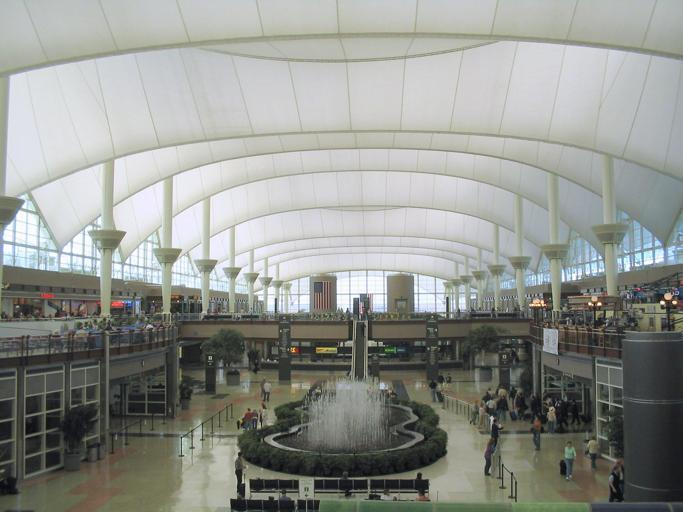

In [22]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [23]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [24]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [25]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [26]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [27]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


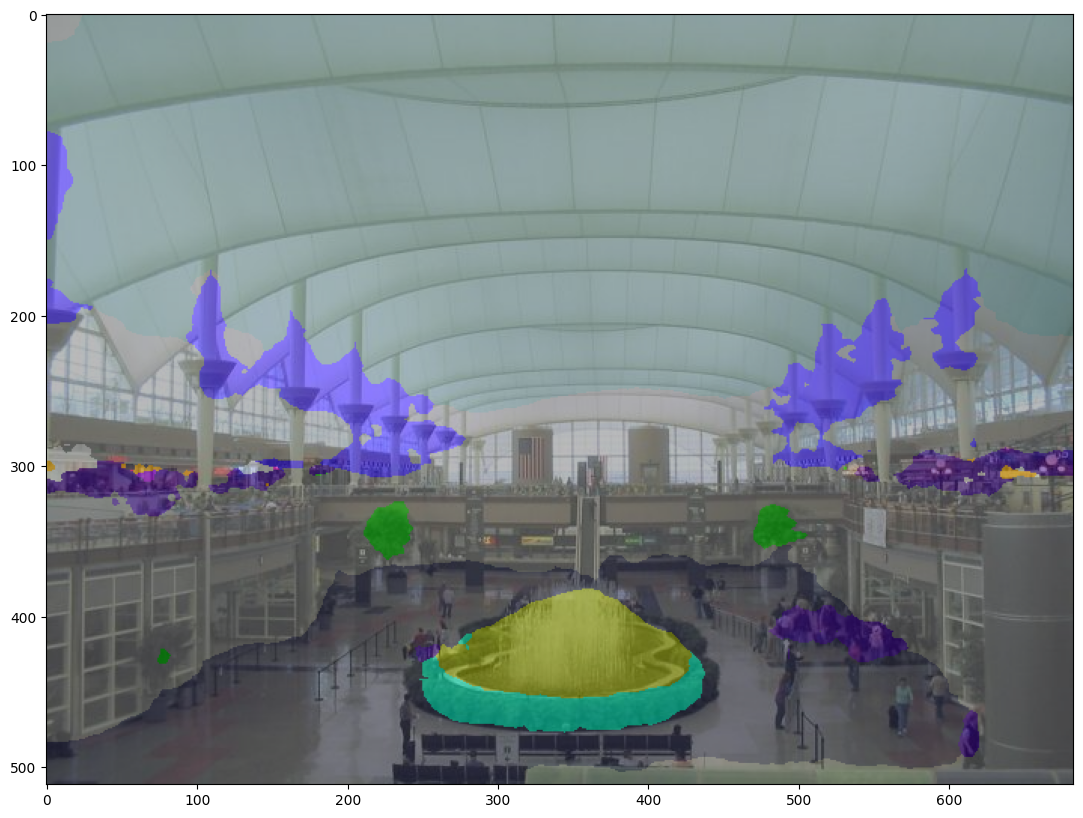

In [28]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

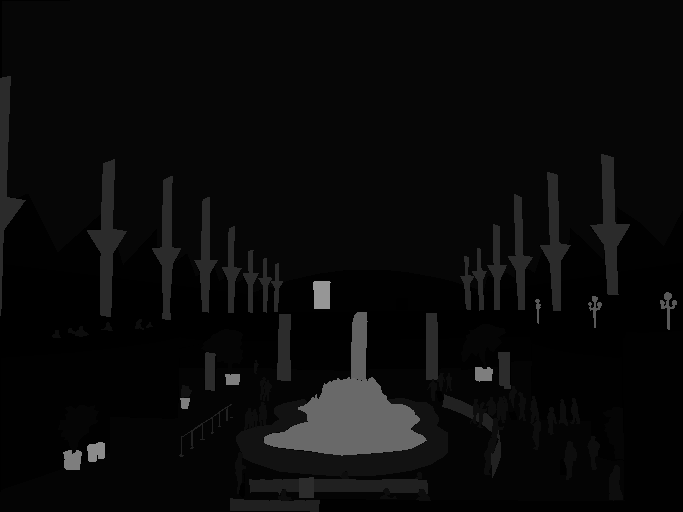

In [29]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


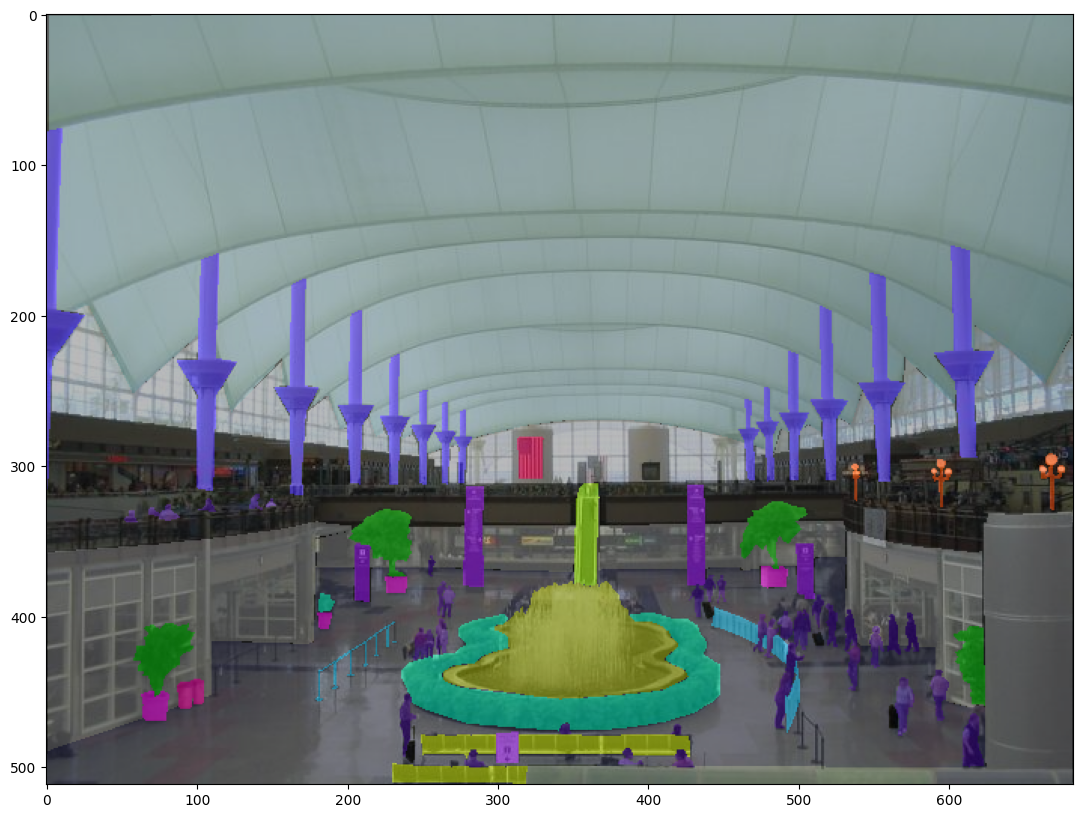

In [30]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [31]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [32]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [33]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.2579863821697108
mean_accuracy 0.3438001229472274
overall_accuracy 0.8544322467480152
---------------------
per-category metrics:


IoU  accuracy
wall      0.700293  0.955641
building       NaN       NaN
sky            NaN       NaN
floor     0.717475  0.936204
tree      0.347936  0.355544
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag      0.000000  0.000000

[150 rows x 2 columns]